In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

## Load model

Tensorflow Lite는 텐서플로 모델을 휴대폰이나 loT기기에서 구동하기 위해 
만들어진 ML툴이다. 

(모바일이나 lot기기를 위해서 텐서플로를 경량화 시킨 버전이라고 생각하면 된다.)
Tensorflow Lite는 타겟이 모바일기기나 lot기기를 위한 만큼 빠른 응답 
속도와 작은 바이너리 사이즈가 특징이다.

In [2]:
# 작성된 모델파일의 경로
interpreter = tf.lite.Interpreter(model_path = "/Users/panhong/Downloads/lite-model_movenet_singlepose_lightning_3.tflite")

# allocate_tensors 함수로 텐서들을 초기화한다.
interpreter.allocate_tensors()

INFO: Initialized TensorFlow Lite runtime.


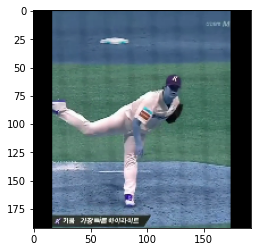

In [22]:
# tf.cast = 텐서를 새로운 형태로 캐스팅하는데 사용 
# 부동소수점형에서 정수형으로 바꾼 경우 소수점을 버리고 출력을 한다. 
# boolean형태인 경우 True이면 1 , False = 0 을 출력한다. 
# boolean형태 = 논리연산 형태 
# cast함수는 조건에 따라 True or False , 1, 0을 출력하는데 여기서는 
# 이미지를 출력하는것이므로 0 ,1 로 출력을 함
# 정수로 출력을 해줌 

# np.squeeze = 배열 , 축 을 통해 지정된 축의 차원을 축소할 수 있음
# img를 int형태로 변경시켜 소수점을 버리고 캐스트를 통해 1 ,0으로 출력을 시킨다음 이미지를 출력
# np.expand_dim = 축의 차원을 확장하는 함수 차원을 축소하는 경우 지정된 축을 대상으로 차원을 축소
plt.imshow(tf.cast(np.squeeze(img) , dtype = tf.int32))

In [21]:
img = frame.copy()
# frame = cap으로 불러온 이미지를 카피한 변수임 

AttributeError: 'NoneType' object has no attribute 'copy'

In [26]:
# 이미지의 차원 확인하기 
img.shape

TensorShape([1, 192, 192, 3])

In [16]:
# 차원을 확장 중심축은 0
np.expand_dims(img , axis = 0).shape

(1, 1, 192, 192, 3)

In [17]:
# 텐서플로 라이트를 사용할때는 input , output의 차원을 잘 맞춰서 넣어주어야 한다.
# 그러기에 tffile의 shape를 확인하는것이 좋다.
# input_details == 모델의 입력세부사항을 가지고 온다. 입출력 모두 항상 차원 및 내부요소들을 잘 맞추어 주어야 한다. 
interpreter.get_input_details()

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 192, 192,   3], dtype=int32),
  'shape_signature': array([  1, 192, 192,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [10]:
# cap = cv2.VideoCapture("/Users/panhong/Desktop/baseball/김진욱.mov")
cap = cv2.VideoCapture(0)
# 영상이 열려있는 동안 지속해서 반복
while cap.isOpened():
    ret , frame = cap.read()
    # 만약 영상이 제대로 가져와 지지 않았다면 반복문을 종료
    if not ret:
        break
    
    # reshape image
    img = frame.copy()
    # 불러온 영상의 프레임(이미지)를 reshape해준다.
    img = tf.image.resize_with_pad(np.expand_dims(img , axis = 0) , 192 , 192)
    # input이미지를 지정 cast는 여기서도 딱히 지정한 부분이 없기에 1 , 0을 출력한다.
    input_image = tf.cast(img , dtype = tf.float32)
    
    # setup input and output
    # 각각의 변수에 interpreter의 내부를 가져온다.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make predictions
    # 입력 텐서의 값을 설정  , 1 : 설정할 텐서의 인덱스 , 2. 설정할 텐서의 값
    interpreter.set_tensor(input_details[0]["index"] , np.array(input_image))
    # invoke를 호출하기 전에 항상 입력크기를 설정하고 텐서를 할당하고 값을 채워야 한다. 
    # 또한 invoke의 호출이 완료되지 않기전에 다른 함수를 호출하면 안된다.
    interpreter.invoke()
    # 출력될 텐서의 값을 가져온다. 1 : 가져올 텐서의 인덱스
    keypoints_with_scores = interpreter.get_tensor(output_details[0]["index"])
    print(keypoints_with_scores)
    
    # Rendering
    draw_keypoints(frame , keypoints_with_scores , 0.4)
    draw_connections(frame , keypoints_with_scores , EDGES , 0.4)
        
    # 모든 전처리 과정을 거치고 난 후에 영상을 출력
    cv2.imshow("Movenet Lighting" , frame)
    
    # "q"버튼을 누르면 windows창을 닫음
    if cv2.waitKey(10) & 0xff == ord("q"
                                    ):
        break

cap.release()
cv2.waitKey()
# 모든 윈도우를 닫음
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)

[[[[0.44972897 0.6391633  0.5477912 ]
   [0.40579504 0.672215   0.71290886]
   [0.40468976 0.5908412  0.67946434]
   [0.4297118  0.69638526 0.58981544]
   [0.4336354  0.51416695 0.70614374]
   [0.65286326 0.7791567  0.49620098]
   [0.6143398  0.35002515 0.7979976 ]
   [0.78069043 0.8339676  0.23338643]
   [0.77977324 0.22974353 0.03545818]
   [0.675552   0.771153   0.5010713 ]
   [0.7230711  0.5419427  0.0312978 ]
   [0.8896288  0.7045382  0.00675556]
   [0.84152454 0.3198917  0.00693849]
   [0.75462055 0.8319824  0.0802573 ]
   [0.7190105  0.5885369  0.0195896 ]
   [0.73659086 0.8103401  0.03374177]
   [0.7246616  0.64800924 0.00565436]]]]


TypeError: '>' not supported between instances of 'module' and 'float'

In [74]:
right_eye = keypoints_with_scores[0][0][2]
left_elbow = keypoints_with_scores[0][0][7]

In [3]:
shaped = np.squeeze(np.multiply(interpreter.get_tensor(interpreter.get_output_details()[0]["index"]) , [480 , 640 , 1]))

In [4]:
for kp in shaped:
    ky , kx , kp_conf = kp
    print(int(ky) , int(kx) , kp_conf) 

0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0


In [41]:
np.array(left_elbow[:2]*[480 , 640]).astype

<function ndarray.astype>

## Draw Keypoints

In [6]:
def draw_keypoints(frame , keypoints , confidence_threshold):
    y , x , c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints , [y , x , 1]))
    
    for kp in shaped:
        ky , kx , kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame , (int(kx) , int(ky)) , 4 , (0 , 255 , 0) , -1)

## Draw Edges

In [9]:
# 각 신체를 연결할 딕셔너리 리스트 
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [94]:
shaped[0] , shaped[1]

(array([3.54289641e+02, 7.48255768e+02, 6.19404078e-01]),
 array([3.28066607e+02, 7.92979584e+02, 6.12715364e-01]))

In [65]:
for edge , color in EDGES.items():
    p1 , p2 = edge
    y1 , x1 , c1 = shaped[p1]
    y2 , x2 , c2 = shaped[p2]
    print((int(x2) , int(y2)))

(348, 211)
(297, 214)
(380, 228)
(257, 231)
(458, 318)
(185, 314)
(524, 363)
(492, 327)
(117, 382)
(221, 299)
(185, 314)
(234, 207)
(222, 193)
(222, 193)
(512, 341)
(503, 323)
(190, 306)
(206, 221)


In [7]:
def draw_connections(frame , keypoints , edges , confidence_threshold):
    y , x , c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints , [y , x , 1]))
    
    for edge , color in edges.items():
        p1 , p2 = edge
        y1 , x1 , c1 = shaped[p1]
        y2 , x2 , c2 = shaped[p2]        
        
        
        if (c1 > confidence_threshold) & (cv2 > confidence_threshold):
            cv2.line(frame , (int(x1) , int(y1)) , (int(x2) , int(y2)) , (255 , 0 , 0) , 2) 

In [11]:
import tensorflow as tf 
import numpy as np 
import cv2
import matplotlib.pyplot as plt

In [12]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [13]:
def draw_keypoints(frame , keypoints , confidence):
    # frame.shape를 하면 영상의  y값 , x값 , 채널값이 출력이 되는데
    # 해당값들을 각각의 변수에다 지정하여 값을 할당해줌
    y , x , c = frame.shape
    # 
    shaped = np.squeeze(np.multiply(keypoints , [y , x , 1]))
    
    for kp in shaped:
        ky , kx , kp_conf = kp 
        if kp_conf > confidence:
            cv2.circle(frame , (int(kx) , int(ky)) , 4 , (0 , 255 , 0) , -1)
            

In [14]:
def draw_connections(frame , keypoints , edges , confidence_threshold):
    y , x , c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints , [y , x , 1]))
    # edges = 상단의 신체를 연결할 부위와 색을 나타냄 
    # edge = 신체부위번호 , color은 색깔
    for edge , color in edges.items():
        # p1 , p2에 각각 값을 할당해줌 edgs = (0 , 1)형식으로 있기때문에 예시를 입력시키면 
        # p1 = 0 , p2 = 1로 값이 할당됨
        p1 , p2 = edge 
        # 
        y1 , x1 , c1 = shaped[p1]
        y2 , x2 , c2 = shaped[p2]        
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame , (int(x1) , int(y1)) , (int(x2) , int(y2)) , (255 , 0 , 0) , 2)

In [15]:
interpreter = tf.lite.Interpreter(model_path =  "/Users/panhong/Downloads/lite-model_movenet_singlepose_lightning_3.tflite")
interpreter.allocate_tensors()

In [28]:
cap = cv2.VideoCapture("/Users/panhong/Desktop/baseball/조상우.mov")
while cap.isOpened():
    ret , frame = cap.read()
    if not ret:
        break
        
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img , axis = 0) , 192 , 192)
    input_image = tf.cast(img , dtype = tf.float32)
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()    
    
    interpreter.set_tensor(input_details[0]["index"] , np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]["index"])
    print(keypoints_with_scores)
    
    draw_keypoints(frame , keypoints_with_scores , 0.4)
    draw_connections(frame , keypoints_with_scores , EDGES ,0.4)
    
    cv2.imshow("motion_tracking" , frame)
    
    
    while cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)

[[[[0.1831535  0.45425522 0.63845456]
   [0.16777489 0.45699692 0.5873111 ]
   [0.16820747 0.46327692 0.4696202 ]
   [0.17697135 0.48076433 0.53809106]
   [0.1767724  0.49746114 0.625162  ]
   [0.24631527 0.47755033 0.69168574]
   [0.24144892 0.54756415 0.6458255 ]
   [0.3765269  0.45813653 0.36433846]
   [0.3696081  0.5147773  0.2818656 ]
   [0.3186609  0.41459593 0.34763244]
   [0.3414385  0.44824314 0.2455801 ]
   [0.4928512  0.49701747 0.7379931 ]
   [0.4936325  0.5401392  0.7540246 ]
   [0.46206284 0.33434838 0.73277867]
   [0.660416   0.496409   0.68190074]
   [0.64430374 0.3381209  0.6079771 ]
   [0.82549304 0.49422118 0.6655126 ]]]]
[[[[0.18576913 0.45876557 0.5593331 ]
   [0.17086564 0.4576641  0.6040454 ]
   [0.16899434 0.4640052  0.415734  ]
   [0.17940986 0.47157788 0.5592916 ]
   [0.17921904 0.4995988  0.6141471 ]
   [0.24711762 0.47479817 0.65725726]
   [0.24149701 0.5505646  0.6542891 ]
   [0.37581587 0.45368278 0.33431032]
   [0.36263824 0.5121791  0.29460752]
   [0.303

[[[[0.18827996 0.45836696 0.41305834]
   [0.17478976 0.45600364 0.6454065 ]
   [0.17211425 0.46437228 0.41515297]
   [0.18252158 0.46592844 0.5366551 ]
   [0.18183029 0.5025158  0.6528301 ]
   [0.25357848 0.465648   0.72792214]
   [0.24470177 0.55758774 0.6635952 ]
   [0.37556002 0.45100707 0.32560098]
   [0.36265308 0.5279982  0.29490417]
   [0.3011464  0.40159935 0.49744466]
   [0.32169133 0.447949   0.30921376]
   [0.49481785 0.49425822 0.7105719 ]
   [0.49601874 0.5439266  0.7882311 ]
   [0.44598755 0.33407396 0.77872074]
   [0.6532402  0.49202976 0.6518517 ]
   [0.6235039  0.3300257  0.641811  ]
   [0.82488203 0.49533102 0.6934091 ]]]]
[[[[0.18835168 0.45843768 0.41444474]
   [0.17484888 0.45602673 0.64611804]
   [0.17215481 0.46444178 0.41587687]
   [0.18258446 0.46588212 0.53649545]
   [0.18181175 0.502625   0.65416455]
   [0.25351617 0.46559215 0.72673815]
   [0.2445612  0.55770075 0.65877616]
   [0.3754395  0.45092934 0.3233826 ]
   [0.36224812 0.52839714 0.29337186]
   [0.301

[[[[0.18996486 0.45965883 0.42642164]
   [0.17711066 0.45700365 0.64038503]
   [0.17413883 0.4666377  0.43063158]
   [0.187101   0.46115786 0.47008333]
   [0.18409853 0.50142705 0.6145028 ]
   [0.25299194 0.45855826 0.6470343 ]
   [0.243897   0.5545901  0.6781822 ]
   [0.37808996 0.4525509  0.35373378]
   [0.36850914 0.52912456 0.33530658]
   [0.30226696 0.4027428  0.4580669 ]
   [0.31895447 0.44797683 0.32389173]
   [0.49622893 0.4910794  0.64634776]
   [0.49698925 0.54249454 0.76046586]
   [0.43596107 0.3365987  0.72499186]
   [0.65357244 0.49021548 0.68218267]
   [0.60733515 0.3296914  0.6499992 ]
   [0.8234755  0.49595663 0.6935029 ]]]]
[[[[0.18924372 0.45895368 0.41983712]
   [0.17646664 0.4566234  0.64111096]
   [0.1734089  0.46612543 0.41826615]
   [0.18646672 0.46157873 0.45639807]
   [0.18363969 0.50132924 0.6162004 ]
   [0.25292176 0.4587456  0.6517712 ]
   [0.24369463 0.55450344 0.67138547]
   [0.37800372 0.45213497 0.35375503]
   [0.3682576  0.5288736  0.3340277 ]
   [0.301

[[[[0.19048516 0.4595216  0.4705652 ]
   [0.17802945 0.45745298 0.61449134]
   [0.17533377 0.46554625 0.3951903 ]
   [0.18846998 0.46371257 0.45545304]
   [0.18355346 0.50174475 0.6372646 ]
   [0.25040045 0.4646595  0.69309497]
   [0.24356383 0.55761683 0.62889224]
   [0.37325105 0.45742616 0.32187796]
   [0.3551616  0.5411489  0.42727757]
   [0.2876553  0.39900303 0.5666639 ]
   [0.31387013 0.44848442 0.29182488]
   [0.49519265 0.48970982 0.6446926 ]
   [0.4988931  0.54447556 0.77750456]
   [0.42011032 0.3418762  0.8080072 ]
   [0.65723485 0.48672003 0.71009034]
   [0.60003734 0.32190302 0.64195037]
   [0.8225423  0.4947827  0.72426397]]]]
[[[[0.19467738 0.45791775 0.5344511 ]
   [0.1825512  0.45441937 0.6362277 ]
   [0.17992273 0.46332353 0.43193835]
   [0.19080417 0.46246418 0.50306314]
   [0.18607335 0.5020042  0.47582683]
   [0.25074756 0.46339643 0.6628328 ]
   [0.24505043 0.55746436 0.6583997 ]
   [0.37358746 0.45732698 0.30382404]
   [0.3656685  0.53890574 0.4061101 ]
   [0.291

[[[[0.19311559 0.44733518 0.62543184]
   [0.17897806 0.44633222 0.6813688 ]
   [0.1786063  0.45881182 0.42649066]
   [0.18635824 0.46107516 0.45379078]
   [0.1841622  0.49646246 0.5745882 ]
   [0.24428421 0.4590808  0.6122432 ]
   [0.24319202 0.5574361  0.6252475 ]
   [0.3505534  0.4196291  0.31894732]
   [0.34921682 0.54029965 0.46486935]
   [0.28501627 0.39487582 0.41917434]
   [0.26364657 0.4336356  0.34004945]
   [0.4959286  0.4876983  0.6113419 ]
   [0.49831757 0.542617   0.7534466 ]
   [0.41116387 0.34126532 0.7906455 ]
   [0.65080523 0.48526067 0.62512183]
   [0.58372384 0.31802338 0.66031635]
   [0.8215923  0.4943423  0.7425387 ]]]]
[[[[0.19294819 0.44761008 0.6208092 ]
   [0.17890441 0.44647527 0.6823429 ]
   [0.1784861  0.4590487  0.4238601 ]
   [0.18633406 0.46091092 0.45507276]
   [0.18401492 0.49652943 0.577988  ]
   [0.24430262 0.45906842 0.6111907 ]
   [0.24300842 0.55732805 0.6248795 ]
   [0.35099286 0.4202889  0.32070994]
   [0.34989727 0.54078746 0.4732865 ]
   [0.285

[[[[0.1966626  0.44814783 0.6365885 ]
   [0.18396556 0.4449868  0.47975796]
   [0.18056898 0.45753264 0.41772392]
   [0.19089411 0.45624322 0.46043146]
   [0.18606162 0.49354503 0.582985  ]
   [0.24944693 0.4542173  0.5929226 ]
   [0.24330048 0.5545143  0.6713991 ]
   [0.36109328 0.41224325 0.22197163]
   [0.3598572  0.5416009  0.48173594]
   [0.29048672 0.40298247 0.4597853 ]
   [0.33054194 0.45534047 0.3820967 ]
   [0.48882532 0.4736341  0.75239825]
   [0.49522257 0.53994036 0.7710079 ]
   [0.39653692 0.34574473 0.8442528 ]
   [0.65648305 0.48376772 0.7272681 ]
   [0.5754093  0.3178324  0.66601396]
   [0.8229758  0.49776873 0.74387276]]]]
[[[[0.19167118 0.4447511  0.6081316 ]
   [0.1793502  0.44484866 0.6291453 ]
   [0.17700288 0.4566242  0.4013502 ]
   [0.188104   0.45740494 0.44357315]
   [0.18397534 0.49578306 0.62729   ]
   [0.24834925 0.44945738 0.6324728 ]
   [0.24437967 0.55602413 0.68861675]
   [0.3586974  0.40853614 0.24566793]
   [0.35448143 0.54686934 0.57088107]
   [0.278

[[[[0.20545772 0.4330188  0.40426496]
   [0.19128065 0.43557656 0.5312983 ]
   [0.18608648 0.44576144 0.4280868 ]
   [0.19641332 0.4483167  0.54358774]
   [0.18907928 0.4851231  0.4654187 ]
   [0.2595336  0.4429726  0.5999453 ]
   [0.24280779 0.54840857 0.66875905]
   [0.3874875  0.35605225 0.5007687 ]
   [0.360064   0.52211237 0.38779482]
   [0.29644904 0.39802927 0.39921   ]
   [0.3535173  0.4593373  0.1900675 ]
   [0.49052247 0.47095892 0.6863901 ]
   [0.49268275 0.5385505  0.7287916 ]
   [0.38984165 0.34880933 0.77618855]
   [0.66422975 0.4800199  0.83625543]
   [0.56598717 0.32148844 0.5648065 ]
   [0.822009   0.49749416 0.7666933 ]]]]
[[[[0.20515344 0.43282872 0.39941463]
   [0.19100033 0.4354707  0.53199404]
   [0.18585476 0.44565696 0.43175268]
   [0.19621629 0.44817305 0.5463805 ]
   [0.18887311 0.4850446  0.46228594]
   [0.2594594  0.44291362 0.5976287 ]
   [0.24270523 0.54832757 0.6666367 ]
   [0.3874848  0.35616183 0.5027037 ]
   [0.35992345 0.5221087  0.38748607]
   [0.296

[[[[0.22378236 0.423372   0.4803108 ]
   [0.20521364 0.42391163 0.47773084]
   [0.19960491 0.43664524 0.4230098 ]
   [0.1998888  0.4403778  0.5948028 ]
   [0.19650123 0.4793608  0.5471533 ]
   [0.26269332 0.42667133 0.57013917]
   [0.24749914 0.5544808  0.7316172 ]
   [0.3879566  0.34967047 0.47649217]
   [0.36232504 0.5336798  0.45385504]
   [0.29428676 0.40100038 0.35542697]
   [0.3694029  0.44564363 0.32611722]
   [0.48943636 0.4667638  0.7320267 ]
   [0.49376914 0.5382883  0.70318806]
   [0.39025217 0.3433884  0.63308716]
   [0.6568173  0.478347   0.67891085]
   [0.5620824  0.33176827 0.44543684]
   [0.8207614  0.49770325 0.6918935 ]]]]
[[[[0.22393563 0.42343968 0.48259866]
   [0.20545433 0.4239332  0.47991633]
   [0.19976783 0.43672702 0.4241637 ]
   [0.20009433 0.44030198 0.59191746]
   [0.19661348 0.47938952 0.54693395]
   [0.26291227 0.42651314 0.57039887]
   [0.24755561 0.55461836 0.7327112 ]
   [0.3880285  0.34959814 0.47832167]
   [0.362375   0.5337157  0.45460448]
   [0.294

[[[[0.22212222 0.4131539  0.51163095]
   [0.20813063 0.41940734 0.4364434 ]
   [0.20357929 0.43183202 0.46179283]
   [0.20473239 0.42979848 0.40855885]
   [0.19598834 0.47084403 0.6033808 ]
   [0.26302916 0.4182992  0.5218791 ]
   [0.24650264 0.54166627 0.660115  ]
   [0.39673683 0.3484591  0.4744889 ]
   [0.36512777 0.5172393  0.43873125]
   [0.5050274  0.35613236 0.24755159]
   [0.43891025 0.44673187 0.25110352]
   [0.49004024 0.46382725 0.6930659 ]
   [0.4924894  0.5302576  0.8082147 ]
   [0.39525598 0.34209257 0.5262704 ]
   [0.6560352  0.47889432 0.7163959 ]
   [0.56025505 0.35221446 0.4472568 ]
   [0.82482374 0.49759609 0.75980324]]]]
[[[[0.22209142 0.4132256  0.5126928 ]
   [0.20810458 0.419477   0.43496528]
   [0.20357916 0.43189496 0.46161258]
   [0.20473915 0.42976582 0.40820205]
   [0.1959981  0.47087806 0.604929  ]
   [0.26297313 0.41819108 0.5197846 ]
   [0.2464968  0.54172844 0.6594267 ]
   [0.39684626 0.34824264 0.47284293]
   [0.36526856 0.5172633  0.4407858 ]
   [0.504

[[[[0.22196272 0.4197018  0.4906134 ]
   [0.20585585 0.4159083  0.4583252 ]
   [0.19969337 0.43051693 0.3889804 ]
   [0.20360762 0.42382216 0.5750041 ]
   [0.19522068 0.4657148  0.67473644]
   [0.26821423 0.41065007 0.5044351 ]
   [0.24547443 0.53512686 0.66680026]
   [0.40737554 0.35703123 0.604169  ]
   [0.36812994 0.515771   0.3981933 ]
   [0.4965578  0.41025218 0.3607486 ]
   [0.4611621  0.46401605 0.2276695 ]
   [0.49075085 0.46269894 0.68011725]
   [0.49483705 0.5314857  0.7982006 ]
   [0.4111408  0.35044253 0.5639007 ]
   [0.65604395 0.4846269  0.7111487 ]
   [0.57090926 0.3763026  0.536819  ]
   [0.81985414 0.49781036 0.7082243 ]]]]
[[[[0.2219886  0.4197123  0.48997477]
   [0.20583653 0.41590387 0.45787483]
   [0.19975054 0.43053982 0.387901  ]
   [0.20359258 0.4237554  0.5763831 ]
   [0.19531316 0.46571457 0.6749482 ]
   [0.2682193  0.41051793 0.5003816 ]
   [0.24564514 0.53518736 0.6701391 ]
   [0.40731344 0.35695    0.60274684]
   [0.3681297  0.51584727 0.39881605]
   [0.496

[[[[0.22433949 0.40073413 0.42941087]
   [0.20635083 0.39690775 0.38069874]
   [0.20551428 0.414158   0.30940732]
   [0.19895391 0.41263908 0.58204687]
   [0.1928888  0.45292598 0.54639965]
   [0.2627714  0.40600085 0.5342056 ]
   [0.24615285 0.5279418  0.6264982 ]
   [0.4114142  0.35585213 0.32695568]
   [0.37115878 0.5161025  0.3298248 ]
   [0.32169524 0.3826774  0.3486901 ]
   [0.36661464 0.42943916 0.25597772]
   [0.49484438 0.4621628  0.69235766]
   [0.495421   0.5398141  0.7318223 ]
   [0.44663322 0.34600243 0.7019049 ]
   [0.65750945 0.49109802 0.7347048 ]
   [0.60869396 0.38269663 0.5163969 ]
   [0.8219168  0.49688667 0.60077775]]]]
[[[[0.22439913 0.40044078 0.42838788]
   [0.20622395 0.3966044  0.37811774]
   [0.20553198 0.41360468 0.30954608]
   [0.19884273 0.41282368 0.5773309 ]
   [0.19292027 0.45259458 0.54928905]
   [0.2627891  0.40657574 0.53388935]
   [0.2462897  0.5278332  0.63056314]
   [0.41188002 0.3560711  0.32729644]
   [0.3723169  0.5155799  0.33152652]
   [0.321

[[[[0.23481113 0.39906237 0.54028547]
   [0.21595094 0.3944808  0.61643887]
   [0.21143207 0.4089757  0.38998392]
   [0.21225762 0.40536484 0.5142821 ]
   [0.203624   0.4410122  0.7028752 ]
   [0.2802171  0.4041726  0.754581  ]
   [0.2568357  0.5160976  0.8181853 ]
   [0.43219444 0.3801489  0.42343885]
   [0.38296527 0.49471137 0.41631883]
   [0.4015621  0.378524   0.24733704]
   [0.40920612 0.4257548  0.29806536]
   [0.49363917 0.47982416 0.7098856 ]
   [0.49064064 0.5573053  0.7465899 ]
   [0.510211   0.36350083 0.6197134 ]
   [0.65174353 0.49904558 0.5685417 ]
   [0.6615268  0.38693616 0.48457044]
   [0.8104845  0.50014555 0.6040117 ]]]]
[[[[0.234767   0.3992953  0.5365142 ]
   [0.2159628  0.39466056 0.6139855 ]
   [0.21143535 0.40925166 0.3902062 ]
   [0.21241699 0.40541512 0.5167318 ]
   [0.20365646 0.44103765 0.7033273 ]
   [0.28025344 0.40417883 0.7548764 ]
   [0.25687343 0.5161126  0.8190311 ]
   [0.43221468 0.3802366  0.42455566]
   [0.38297567 0.49469775 0.4176754 ]
   [0.401

[[[[0.2579452  0.38502502 0.59081775]
   [0.24070045 0.38019678 0.6460379 ]
   [0.23852544 0.39910254 0.4140866 ]
   [0.24066614 0.38936555 0.64797115]
   [0.2298858  0.43252668 0.56008375]
   [0.31492662 0.391338   0.56288564]
   [0.28619677 0.5017195  0.6714892 ]
   [0.44008553 0.39507282 0.5554067 ]
   [0.39089164 0.5100875  0.40127215]
   [0.42370683 0.37214324 0.38275063]
   [0.40977895 0.42356586 0.2876857 ]
   [0.50933075 0.47523972 0.7398037 ]
   [0.50511503 0.56337464 0.71267116]
   [0.6181008  0.39784563 0.44505835]
   [0.65884054 0.4923434  0.78434116]
   [0.7920563  0.39177307 0.662047  ]
   [0.81178    0.5060344  0.6163933 ]]]]
[[[[0.2578133  0.3849324  0.58951646]
   [0.24053954 0.38017935 0.6470316 ]
   [0.23837632 0.3990378  0.41636956]
   [0.24052143 0.3893778  0.649315  ]
   [0.22978064 0.43263492 0.5570524 ]
   [0.31485218 0.3914457  0.56595474]
   [0.28601426 0.5018865  0.671904  ]
   [0.4401639  0.39552563 0.5536594 ]
   [0.39059573 0.5100705  0.398134  ]
   [0.422

[[[[0.28820026 0.36922854 0.7072755 ]
   [0.27137095 0.36838418 0.5977266 ]
   [0.27138844 0.37835538 0.42732075]
   [0.27349776 0.38944468 0.57025594]
   [0.27065623 0.40848094 0.63223064]
   [0.34202704 0.38655862 0.69033086]
   [0.33361006 0.47751677 0.7332199 ]
   [0.4693206  0.37491375 0.6321998 ]
   [0.4570045  0.46019742 0.31731796]
   [0.56645113 0.32825902 0.7662727 ]
   [0.5327566  0.42013475 0.19022644]
   [0.52481776 0.48946184 0.78094363]
   [0.52611303 0.56743693 0.67206633]
   [0.656176   0.40635955 0.7584752 ]
   [0.65452325 0.47229695 0.72239447]
   [0.8195712  0.39836928 0.6296745 ]
   [0.80513614 0.50152266 0.5137532 ]]]]
[[[[0.28732264 0.36894608 0.7244293 ]
   [0.27057782 0.3682284  0.5808828 ]
   [0.27056366 0.37807044 0.41476133]
   [0.27304393 0.38957044 0.5670164 ]
   [0.2701379  0.4082843  0.6292976 ]
   [0.34204552 0.38653514 0.69294006]
   [0.3332824  0.47763488 0.7298534 ]
   [0.46948785 0.37481636 0.6340306 ]
   [0.45671827 0.46086836 0.31058052]
   [0.566

[[[[0.34633064 0.35434383 0.6197195 ]
   [0.3300013  0.3524917  0.41883892]
   [0.33006546 0.36137927 0.45848048]
   [0.3369716  0.38433826 0.5587893 ]
   [0.33562347 0.39963648 0.5399791 ]
   [0.40087217 0.39389873 0.4780798 ]
   [0.39107108 0.45632812 0.65893865]
   [0.50762415 0.3501     0.5798206 ]
   [0.5013901  0.4291738  0.29081962]
   [0.5818527  0.3003652  0.56149375]
   [0.5443986  0.3438292  0.17404893]
   [0.56372225 0.5115774  0.633224  ]
   [0.56350946 0.5700923  0.69304967]
   [0.6618662  0.38989437 0.62764484]
   [0.6515839  0.43263888 0.43036908]
   [0.8337471  0.3956828  0.5264085 ]
   [0.7981557  0.49483532 0.72859347]]]]
[[[[0.3617997  0.35892254 0.46846008]
   [0.34818894 0.35591084 0.3686418 ]
   [0.34988087 0.36985368 0.34112793]
   [0.3554189  0.37672192 0.50089526]
   [0.35057482 0.39919373 0.65820825]
   [0.41387826 0.3891706  0.5408067 ]
   [0.40102607 0.45429206 0.6602134 ]
   [0.5157465  0.34258732 0.4715894 ]
   [0.51661587 0.42629337 0.25114864]
   [0.583

[[[[0.4396727  0.35309058 0.47918028]
   [0.42135876 0.34901723 0.53729   ]
   [0.4201449  0.35745382 0.3398648 ]
   [0.40637848 0.3723064  0.4537318 ]
   [0.40310585 0.3874979  0.33742452]
   [0.44363493 0.39760682 0.6231133 ]
   [0.43842372 0.44607443 0.578441  ]
   [0.5364315  0.34608692 0.15152842]
   [0.5292114  0.41732964 0.22671828]
   [0.54378414 0.31209847 0.3309942 ]
   [0.52079016 0.35002154 0.3564071 ]
   [0.6097208  0.5296814  0.65516984]
   [0.60604286 0.5775261  0.7306056 ]
   [0.6726639  0.3667587  0.83498275]
   [0.669032   0.43477938 0.48939744]
   [0.81573606 0.40287408 0.5208145 ]
   [0.7947728  0.48825535 0.6756651 ]]]]
[[[[0.45101187 0.35198557 0.3813628 ]
   [0.4346544  0.35345694 0.536517  ]
   [0.43026146 0.35669184 0.24757728]
   [0.41725457 0.37452626 0.4399169 ]
   [0.41052556 0.39208624 0.4037745 ]
   [0.4592863  0.39554748 0.5057402 ]
   [0.448361   0.45144242 0.66927   ]
   [0.5463805  0.3656441  0.18349949]
   [0.53817    0.43417615 0.2763319 ]
   [0.553

[[[[0.43862242 0.35713398 0.4374559 ]
   [0.42361075 0.36123607 0.40511864]
   [0.41977566 0.36390227 0.2585535 ]
   [0.415618   0.36963063 0.3507366 ]
   [0.41016775 0.3967186  0.5798491 ]
   [0.46672356 0.38446614 0.61023974]
   [0.4511186  0.47747052 0.6182647 ]
   [0.516728   0.27747363 0.40362278]
   [0.48771024 0.56659025 0.7045575 ]
   [0.5240153  0.29336128 0.2502309 ]
   [0.53519446 0.5418654  0.22074705]
   [0.64039207 0.51247644 0.74000937]
   [0.63600135 0.5812279  0.7531048 ]
   [0.6851503  0.36864847 0.7953446 ]
   [0.67704654 0.40290225 0.37967527]
   [0.808673   0.43880314 0.36964464]
   [0.79061407 0.47798428 0.545387  ]]]]
[[[[0.43887374 0.3650633  0.46546727]
   [0.42517477 0.35893953 0.3813325 ]
   [0.42238283 0.37087783 0.28471887]
   [0.41471013 0.37237352 0.4423511 ]
   [0.40486038 0.4025999  0.64362574]
   [0.46734783 0.3855265  0.60953265]
   [0.44528747 0.48757777 0.570458  ]
   [0.5123667  0.27291945 0.5094179 ]
   [0.47230992 0.5661345  0.5337245 ]
   [0.520

[[[[0.42004618 0.36622593 0.47018433]
   [0.40924364 0.3606211  0.55817246]
   [0.40404582 0.3732793  0.36894414]
   [0.401564   0.37210023 0.43595824]
   [0.3886714  0.4124491  0.4968908 ]
   [0.457856   0.38732475 0.50646806]
   [0.4217745  0.5060103  0.51703197]
   [0.5144165  0.30545545 0.52791697]
   [0.42926002 0.5659699  0.50376123]
   [0.49712616 0.32535195 0.25994045]
   [0.47000742 0.5000475  0.31568652]
   [0.67300355 0.5242429  0.5852742 ]
   [0.6592401  0.5736023  0.6768931 ]
   [0.6797241  0.3953274  0.5947576 ]
   [0.6740476  0.4100533  0.5692034 ]
   [0.8322141  0.478478   0.40948105]
   [0.80567664 0.47504318 0.3993979 ]]]]
[[[[0.42007327 0.3663268  0.4689401 ]
   [0.40929592 0.36075932 0.5592582 ]
   [0.4040345  0.37333152 0.36917487]
   [0.40178597 0.37217328 0.43639114]
   [0.38872313 0.4124365  0.4965496 ]
   [0.45819756 0.38743138 0.50961816]
   [0.42170805 0.5062083  0.5135824 ]
   [0.51462597 0.30543143 0.5253669 ]
   [0.42912754 0.5659625  0.504603  ]
   [0.497

[[[[0.39912567 0.38057587 0.45447844]
   [0.3903556  0.37926757 0.5054636 ]
   [0.38298732 0.3894614  0.33154416]
   [0.38816804 0.38355702 0.56328416]
   [0.3755898  0.42343482 0.554657  ]
   [0.453151   0.3871188  0.5135821 ]
   [0.41337892 0.49993667 0.4409133 ]
   [0.5275051  0.33182642 0.49869388]
   [0.3980322  0.5694549  0.7047938 ]
   [0.51805574 0.3652434  0.19707933]
   [0.44305468 0.49474502 0.23996079]
   [0.66145945 0.5286044  0.5218051 ]
   [0.6461956  0.5436896  0.48919284]
   [0.69574803 0.41495582 0.64123845]
   [0.6853852  0.4156853  0.46162266]
   [0.8523179  0.47869086 0.48287055]
   [0.8373201  0.46811175 0.37215889]]]]
[[[[0.40049502 0.3810136  0.45477995]
   [0.39141035 0.37966108 0.5002323 ]
   [0.38452062 0.38944435 0.33517778]
   [0.38861024 0.38398272 0.56476724]
   [0.37655944 0.4226682  0.55380374]
   [0.45354426 0.3874987  0.49971688]
   [0.41413268 0.50003976 0.43965062]
   [0.52746093 0.3316935  0.48694015]
   [0.39779633 0.5700041  0.70075107]
   [0.517

[[[[0.39999777 0.3881517  0.5256649 ]
   [0.38333356 0.39010617 0.61196405]
   [0.3831143  0.38703656 0.52840364]
   [0.37454757 0.41239044 0.37398112]
   [0.37032056 0.40909296 0.43500084]
   [0.43869185 0.43278977 0.4306789 ]
   [0.41970325 0.4770131  0.34237927]
   [0.552459   0.3721995  0.4460837 ]
   [0.3939309  0.5752421  0.48807952]
   [0.5200566  0.3956555  0.29120308]
   [0.46883905 0.4751552  0.14299086]
   [0.64681756 0.52841413 0.42743462]
   [0.63804674 0.49012646 0.5799029 ]
   [0.7077321  0.425783   0.51447827]
   [0.707047   0.4127437  0.360362  ]
   [0.8714687  0.47481233 0.47196573]
   [0.846805   0.45394468 0.2995211 ]]]]
[[[[0.39317173 0.3897391  0.53437006]
   [0.37853226 0.38962543 0.54293305]
   [0.37547672 0.3923607  0.39987624]
   [0.36765194 0.41124746 0.45128632]
   [0.3621102  0.4198494  0.5032986 ]
   [0.43317205 0.435853   0.41232616]
   [0.41589162 0.4837204  0.33687875]
   [0.55207765 0.38046104 0.40356308]
   [0.39274716 0.57804286 0.51755077]
   [0.523

[[[[0.37654635 0.39942133 0.46146363]
   [0.36936903 0.40891418 0.5744606 ]
   [0.36810386 0.3985719  0.5226298 ]
   [0.36232826 0.43870115 0.49331594]
   [0.3612115  0.41201445 0.37843356]
   [0.41216156 0.4882977  0.43946773]
   [0.41289565 0.4062394  0.3553579 ]
   [0.45240116 0.52233505 0.17597374]
   [0.51207757 0.43006688 0.1839512 ]
   [0.44974643 0.50714767 0.29665804]
   [0.45080715 0.5072663  0.27494687]
   [0.64571553 0.51723063 0.48870423]
   [0.645269   0.44570726 0.5506435 ]
   [0.72448826 0.4715476  0.31114528]
   [0.72942734 0.41611764 0.44081974]
   [0.8830664  0.4686906  0.39852765]
   [0.87179697 0.45627618 0.3804928 ]]]]
[[[[0.37620384 0.3998258  0.46920365]
   [0.36857253 0.40922865 0.57371885]
   [0.36722824 0.3988471  0.52902436]
   [0.36163557 0.4387961  0.49296096]
   [0.36026752 0.4121117  0.37980342]
   [0.41217288 0.48830637 0.44059902]
   [0.41245604 0.4066782  0.35165936]
   [0.45282638 0.5221282  0.17587057]
   [0.51246387 0.43116638 0.185871  ]
   [0.449

[[[[0.3661482  0.47688675 0.35747635]
   [0.35838696 0.4810972  0.37137896]
   [0.355658   0.4754457  0.3485965 ]
   [0.36582184 0.4808671  0.40849742]
   [0.35431683 0.46317297 0.30225348]
   [0.44326147 0.5277929  0.46199444]
   [0.41085863 0.4185297  0.34438446]
   [0.52036536 0.54147863 0.3421247 ]
   [0.5469003  0.47781882 0.18693143]
   [0.49123916 0.5288824  0.24130672]
   [0.47889382 0.5128361  0.28053245]
   [0.6531751  0.515115   0.63336515]
   [0.6551913  0.42935094 0.6690818 ]
   [0.77236366 0.4810608  0.49306884]
   [0.78510296 0.4166115  0.5212488 ]
   [0.89025056 0.46649095 0.31197792]
   [0.87318844 0.45366523 0.20612928]]]]
[[[[0.36763304 0.4770726  0.35709572]
   [0.3602531  0.4813946  0.3781386 ]
   [0.35753936 0.4756765  0.36048287]
   [0.36807823 0.48151326 0.41984624]
   [0.35626477 0.4638219  0.30356854]
   [0.4449472  0.52879304 0.4520789 ]
   [0.41241664 0.41888523 0.3601784 ]
   [0.5219332  0.54145104 0.33492982]
   [0.54879934 0.47704726 0.1820043 ]
   [0.492

[[[[0.36035535 0.46425742 0.21985728]
   [0.35434133 0.4648059  0.36720055]
   [0.35589442 0.47073925 0.37651277]
   [0.37789375 0.48954353 0.29234788]
   [0.38041222 0.49492833 0.38016546]
   [0.43266532 0.47601578 0.31921884]
   [0.43131644 0.48832798 0.45924255]
   [0.54563403 0.6004629  0.34037513]
   [0.54242283 0.6016787  0.34906062]
   [0.52998555 0.5556731  0.22545195]
   [0.53606343 0.5554975  0.23188764]
   [0.6171644  0.46397373 0.27897063]
   [0.6184634  0.45749444 0.32302123]
   [0.7536563  0.48552245 0.31954154]
   [0.73202604 0.5028794  0.26276278]
   [0.9144366  0.4645711  0.33665568]
   [0.90148014 0.46166763 0.3325572 ]]]]
[[[[0.3603689  0.46408677 0.21908996]
   [0.35445553 0.46485493 0.36635113]
   [0.35589355 0.47058415 0.37674305]
   [0.37815636 0.49008232 0.2981103 ]
   [0.38047415 0.49482784 0.37993857]
   [0.4329918  0.47738844 0.32388747]
   [0.4308512  0.48748803 0.45298263]
   [0.5455896  0.6004481  0.34953666]
   [0.54198444 0.60134023 0.3486117 ]
   [0.530

[[[[0.4003417  0.5010623  0.38273454]
   [0.39173645 0.515787   0.45110294]
   [0.38864332 0.49554396 0.6202382 ]
   [0.40759188 0.5439932  0.6181536 ]
   [0.38966596 0.49100512 0.58308536]
   [0.49157548 0.5614534  0.5837756 ]
   [0.42840052 0.42970154 0.549599  ]
   [0.59071743 0.60910773 0.4684261 ]
   [0.43179628 0.37122273 0.6630843 ]
   [0.56707704 0.5696945  0.31156802]
   [0.32544842 0.42700303 0.49189097]
   [0.65993387 0.49777424 0.58949727]
   [0.6459733  0.40781793 0.6101016 ]
   [0.7763518  0.4851262  0.4783791 ]
   [0.7708882  0.40177143 0.5077231 ]
   [0.9181008  0.4670373  0.41513717]
   [0.86783004 0.4593897  0.33836296]]]]
[[[[0.40036005 0.50117743 0.38272387]
   [0.39178395 0.515805   0.4509075 ]
   [0.3887136  0.4956361  0.6199448 ]
   [0.4077347  0.5439342  0.6192579 ]
   [0.3898538  0.49102518 0.58160925]
   [0.49189973 0.5615197  0.5841072 ]
   [0.42838985 0.4297772  0.54977465]
   [0.590879   0.60878056 0.46795362]
   [0.43167531 0.3713047  0.66483724]
   [0.567

[[[[0.4036486  0.52585894 0.4325723 ]
   [0.39269862 0.54395413 0.56882197]
   [0.3852617  0.5166594  0.61551684]
   [0.41123828 0.5592884  0.6270663 ]
   [0.39526933 0.49351174 0.6090142 ]
   [0.49976212 0.5768452  0.6164281 ]
   [0.44330734 0.43451247 0.35167035]
   [0.60310584 0.6196376  0.57062745]
   [0.4282168  0.3318581  0.34320182]
   [0.58837783 0.5927094  0.3601874 ]
   [0.33931798 0.3956554  0.41474319]
   [0.6669981  0.49684045 0.52680093]
   [0.63966763 0.4003272  0.633779  ]
   [0.72640485 0.49761456 0.4598696 ]
   [0.7692146  0.39593837 0.49103588]
   [0.91421497 0.45844012 0.32219929]
   [0.78015697 0.43043184 0.14172482]]]]
[[[[0.40369877 0.5260235  0.43651655]
   [0.39281282 0.54413074 0.56932116]
   [0.38524613 0.51674414 0.61560553]
   [0.41145238 0.55934834 0.62596494]
   [0.39521134 0.49334168 0.61307085]
   [0.50006425 0.5767824  0.61562324]
   [0.44313538 0.43439436 0.35180426]
   [0.603362   0.6198483  0.57348317]
   [0.42793226 0.33174413 0.3450418 ]
   [0.588

[[[[0.4209832  0.5341067  0.3908683 ]
   [0.4088241  0.5510949  0.59965146]
   [0.40104622 0.521271   0.55449   ]
   [0.42415842 0.56546915 0.6293293 ]
   [0.406529   0.50380886 0.5802139 ]
   [0.5217922  0.57729596 0.67560756]
   [0.44760773 0.44145    0.57721394]
   [0.63826287 0.5895026  0.39888805]
   [0.4323548  0.33468604 0.4344985 ]
   [0.6655126  0.51650894 0.23527259]
   [0.41110933 0.32459846 0.33979207]
   [0.6649091  0.49896318 0.5508783 ]
   [0.6313599  0.40169865 0.5547905 ]
   [0.738826   0.48068762 0.46435425]
   [0.7605876  0.38746333 0.5460981 ]
   [0.9078026  0.4621114  0.42582333]
   [0.78007    0.41105586 0.15380117]]]]
[[[[0.42155522 0.53381383 0.3974166 ]
   [0.40927106 0.5509694  0.58898073]
   [0.4017192  0.5210854  0.55450857]
   [0.42461997 0.56516975 0.6276154 ]
   [0.4068333  0.5037378  0.57936007]
   [0.5222958  0.57703716 0.67187715]
   [0.44775844 0.4411107  0.5778919 ]
   [0.63896555 0.58885217 0.39355057]
   [0.4325655  0.3349781  0.4332902 ]
   [0.665

[[[[0.43377206 0.5460603  0.49041876]
   [0.42373556 0.563846   0.552335  ]
   [0.4148507  0.534272   0.39701658]
   [0.43415758 0.5744922  0.5779151 ]
   [0.41652605 0.5092761  0.5911489 ]
   [0.5314384  0.5855714  0.7621311 ]
   [0.45332158 0.45126092 0.7025008 ]
   [0.63022465 0.57831955 0.45963383]
   [0.4509129  0.35189396 0.6310408 ]
   [0.60981864 0.5597111  0.3691367 ]
   [0.38515174 0.26141322 0.46698382]
   [0.66922617 0.4909949  0.59906715]
   [0.6459285  0.40351176 0.7136566 ]
   [0.77041906 0.47889102 0.4108864 ]
   [0.7875051  0.371031   0.49339297]
   [0.9036919  0.4565003  0.33956087]
   [0.7827658  0.376002   0.39045435]]]]
[[[[0.4332082  0.5462097  0.50932854]
   [0.4208475  0.56153756 0.40688193]
   [0.4143015  0.5344199  0.3937921 ]
   [0.43372715 0.57457936 0.56821126]
   [0.4161485  0.5094074  0.5842321 ]
   [0.5313943  0.5853152  0.7602332 ]
   [0.45317143 0.45149952 0.6979502 ]
   [0.6303503  0.5783513  0.45770478]
   [0.45086253 0.351866   0.6343417 ]
   [0.609

[[[[0.44623792 0.5560031  0.4301193 ]
   [0.4325258  0.5694461  0.5914669 ]
   [0.42964405 0.5405389  0.5394802 ]
   [0.44009966 0.5721731  0.48787594]
   [0.42728516 0.5154752  0.6777057 ]
   [0.5322884  0.5915711  0.6902847 ]
   [0.4626263  0.45525432 0.42624655]
   [0.62881935 0.57036734 0.3983    ]
   [0.4596375  0.38454315 0.32582074]
   [0.5952585  0.57258636 0.2808782 ]
   [0.4817074  0.42345965 0.27148667]
   [0.6553454  0.49576542 0.5489112 ]
   [0.6176998  0.40051192 0.59047526]
   [0.81463027 0.477877   0.3964108 ]
   [0.8019361  0.361583   0.58413625]
   [0.9136473  0.45506352 0.2976786 ]
   [0.7862396  0.40010688 0.2750384 ]]]]
[[[[0.4462232  0.5568651  0.42312837]
   [0.43245447 0.5699235  0.5949464 ]
   [0.42963797 0.5410789  0.5499187 ]
   [0.43988472 0.57208407 0.48344886]
   [0.42749375 0.5155039  0.6794967 ]
   [0.53205407 0.5914582  0.68813264]
   [0.46319124 0.4551866  0.42320636]
   [0.6284956  0.5706793  0.400822  ]
   [0.46013412 0.38460898 0.32613486]
   [0.595

[[[[0.4438772  0.5592026  0.3660615 ]
   [0.4334417  0.57006353 0.50342816]
   [0.4266193  0.5491307  0.50714153]
   [0.4412068  0.5732504  0.43876168]
   [0.42330882 0.526151   0.45842206]
   [0.52564263 0.5827935  0.5547438 ]
   [0.45370862 0.46285126 0.45904037]
   [0.59703463 0.5774641  0.35420078]
   [0.47892305 0.41881794 0.30037326]
   [0.5688249  0.55161095 0.21908587]
   [0.49762678 0.44880292 0.30997244]
   [0.6592937  0.49709308 0.51513886]
   [0.6160792  0.4040868  0.52967256]
   [0.83318233 0.4633022  0.5204445 ]
   [0.7991072  0.36747453 0.6452562 ]
   [0.8091049  0.44319367 0.16512373]
   [0.77839315 0.4079281  0.24083796]]]]
[[[[0.44493258 0.54655564 0.2939428 ]
   [0.43441164 0.5598793  0.45491588]
   [0.43315226 0.5445684  0.39964533]
   [0.44242722 0.5680911  0.33699137]
   [0.4281685  0.53116226 0.42504308]
   [0.51778316 0.5823699  0.4262327 ]
   [0.45653105 0.48193178 0.31226724]
   [0.58848774 0.5830577  0.27591982]
   [0.47673616 0.42830104 0.31414592]
   [0.546

[[[[0.477413   0.55127716 0.2968769 ]
   [0.45882148 0.5687146  0.38854167]
   [0.45517898 0.5473226  0.41012347]
   [0.46194896 0.58546484 0.33903158]
   [0.44958517 0.5337619  0.4970357 ]
   [0.5162092  0.5953858  0.49635583]
   [0.48989844 0.48233783 0.5552443 ]
   [0.5864248  0.5892744  0.35460913]
   [0.5855206  0.50901836 0.11936525]
   [0.5614757  0.5557792  0.16212249]
   [0.5481312  0.5497241  0.25243843]
   [0.5930715  0.503188   0.42847604]
   [0.56430936 0.41674504 0.38947752]
   [0.72748697 0.47145402 0.5186669 ]
   [0.776477   0.36474535 0.61574805]
   [0.8487719  0.45490083 0.20292598]
   [0.7747624  0.3897934  0.2756644 ]]]]
[[[[0.49252972 0.5443585  0.3400563 ]
   [0.47340786 0.5669397  0.4605987 ]
   [0.47655088 0.5355167  0.42165276]
   [0.4675842  0.5819441  0.37160134]
   [0.46277067 0.5175125  0.42890215]
   [0.5137629  0.59634745 0.55794597]
   [0.50105053 0.47524565 0.5385984 ]
   [0.5803413  0.58749837 0.3495751 ]
   [0.59201026 0.47353083 0.19326773]
   [0.556

[[[[0.4855559  0.5765357  0.42143333]
   [0.4697343  0.59124154 0.47974303]
   [0.47054085 0.5676373  0.3990138 ]
   [0.46885738 0.59901863 0.3481853 ]
   [0.46297342 0.5503836  0.4335099 ]
   [0.5001278  0.5999652  0.5262673 ]
   [0.50051546 0.48679203 0.58666486]
   [0.568735   0.56581384 0.30512905]
   [0.60721767 0.5086709  0.3620313 ]
   [0.57587415 0.56199664 0.29787832]
   [0.58350354 0.5391874  0.418776  ]
   [0.58849186 0.4708317  0.31427053]
   [0.5696999  0.3820927  0.53671324]
   [0.7010232  0.45500588 0.38407928]
   [0.72516817 0.4469691  0.22130862]
   [0.87617826 0.45799673 0.3788067 ]
   [0.881324   0.45579338 0.31331527]]]]
[[[[0.48573017 0.5766052  0.42276102]
   [0.46996412 0.5913726  0.4786506 ]
   [0.4709888  0.5676052  0.3998781 ]
   [0.46898863 0.5991368  0.3484434 ]
   [0.46328875 0.55022585 0.43713242]
   [0.5000107  0.6001099  0.52710843]
   [0.5007906  0.48672748 0.592103  ]
   [0.5686621  0.5660372  0.304028  ]
   [0.6069844  0.5089382  0.361922  ]
   [0.575

[[[[0.5171218  0.5936119  0.2662739 ]
   [0.50020957 0.6024598  0.1655024 ]
   [0.49793637 0.6000248  0.22669473]
   [0.4559791  0.6095127  0.2203364 ]
   [0.456315   0.59478515 0.12884897]
   [0.44987887 0.58181673 0.2665344 ]
   [0.44871068 0.54983604 0.28382552]
   [0.5096627  0.58029646 0.23184565]
   [0.48593903 0.50535524 0.1750646 ]
   [0.57495475 0.5438391  0.2404306 ]
   [0.575242   0.51170444 0.1519869 ]
   [0.5439457  0.4782117  0.35965538]
   [0.52807504 0.4299756  0.2972749 ]
   [0.6779094  0.48374653 0.20091763]
   [0.70280784 0.4397593  0.33868742]
   [0.87272096 0.45182294 0.31873578]
   [0.8668651  0.44765377 0.30092517]]]]
[[[[0.5007241  0.59594524 0.2013661 ]
   [0.49849367 0.60289145 0.17264125]
   [0.4961486  0.5996222  0.22296855]
   [0.45620236 0.6101407  0.23228294]
   [0.45602715 0.5938684  0.14152992]
   [0.45020458 0.585147   0.2756371 ]
   [0.4483089  0.547313   0.31082982]
   [0.5101729  0.58117646 0.25762725]
   [0.48411784 0.5047758  0.18002686]
   [0.575

[[[[0.4040957  0.64545566 0.44237477]
   [0.3974517  0.6515968  0.36998212]
   [0.3962481  0.6359914  0.3435587 ]
   [0.417783   0.64584905 0.30736017]
   [0.41848236 0.6136529  0.3222733 ]
   [0.4467464  0.6254169  0.4361439 ]
   [0.42217278 0.5549092  0.41355377]
   [0.48835254 0.577734   0.25429428]
   [0.43932205 0.5597255  0.20426843]
   [0.44369683 0.5804815  0.22828555]
   [0.42457527 0.56926644 0.27800784]
   [0.5521519  0.4617381  0.55316687]
   [0.5020524  0.39963478 0.55440503]
   [0.6779963  0.44323736 0.4907551 ]
   [0.5876147  0.26478907 0.67906237]
   [0.8674998  0.44779456 0.558961  ]
   [0.4775972  0.24157754 0.7355539 ]]]]
[[[[0.43837553 0.6411631  0.14879522]
   [0.4182181  0.6584637  0.22986034]
   [0.40562135 0.6445075  0.3465615 ]
   [0.42051968 0.6561279  0.20255825]
   [0.41346294 0.63447285 0.20365974]
   [0.43399975 0.64331424 0.26182473]
   [0.392367   0.58215445 0.28568578]
   [0.46751124 0.59022117 0.21556035]
   [0.39351735 0.57830185 0.19906783]
   [0.463

[[[[0.40413117 0.66451883 0.11120984]
   [0.36574095 0.6621021  0.29087818]
   [0.3901657  0.66722506 0.19715017]
   [0.3678994  0.6589515  0.28118798]
   [0.3949352  0.67226    0.18092763]
   [0.35741574 0.6160754  0.33702603]
   [0.42752013 0.6561787  0.5492991 ]
   [0.38059062 0.5667094  0.16933796]
   [0.48950815 0.62052894 0.35559076]
   [0.42810208 0.52497613 0.09527129]
   [0.48479646 0.5964327  0.13459426]
   [0.4733302  0.43579933 0.59730715]
   [0.5164073  0.4804361  0.66872483]
   [0.5453384  0.244565   0.789394  ]
   [0.693153   0.4536636  0.6637037 ]
   [0.416299   0.11810794 0.43849096]
   [0.86761606 0.44594678 0.58636546]]]]
[[[[0.40388152 0.66540813 0.11752927]
   [0.36628604 0.6625628  0.29268295]
   [0.3899148  0.66791606 0.19870448]
   [0.36811683 0.6589402  0.28570837]
   [0.39457417 0.6723439  0.18512842]
   [0.35816988 0.61670274 0.3394723 ]
   [0.42721415 0.6562102  0.54967505]
   [0.38186824 0.56584215 0.16546366]
   [0.4902172  0.6203506  0.35636067]
   [0.428

-1